# Кластерный анализ

---

**Кластерный анализ** позволяет разбить множество исследуемых объектов и признаков на однородные в некотором смысле группы, или кластеры.

Проведём кластерный анализ на следующих стандартизованных переменных: Часы учебы/нед, Процент посещ, Сон (ч/сут), Рез. пр. экз, Занятия с реп, Физ. активность, Итоговый балл.

Ниже представлены две таблицы: в первой – таблица средних для каждого кластера, во второй – под диагональю евклидовы расстояния между кластерами, над диагональю квадраты расстояний.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean

df = pd.read_csv("../data/student_perfomance_sample.csv")

vars = ["study_hours_week", "attendance_pct", "sleep_hours", "prev_exam_score", "tutoring_sessions_month", "physical_activity_hours", "final_exam_score"]
data = df[vars].dropna()
scaler = StandardScaler()   
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=vars)

def k_means(data_scaled):
    df_k = data_scaled.copy()
    kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto')
    labels = kmeans.fit_predict(data_scaled)
    df_k["cluster"] = labels
    
    cluster_means = df_k.groupby("cluster")[vars].mean().T
    cluster_means.columns = ["Кластер 1", "Кластер 2", "Кластер 3"]
    print("Средние кластеров:")
    display(cluster_means)
    
    centroids = kmeans.cluster_centers_
    dist_matrix = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            if i == j:
                dist_matrix[i, j] = 0
            elif i > j:
                d = euclidean(centroids[i], centroids[j])
                dist_matrix[i, j] = d                         
            else:
                d = euclidean(centroids[i], centroids[j])
                dist_matrix[i, j] = d**2
                
    dist_table = pd.DataFrame(dist_matrix, index=["Кластер 1", "Кластер 2", "Кластер 3"], columns=["Кластер 1", "Кластер 2", "Кластер 3"])
    print("Евклидовы расстояния между кластерами:")
    display(dist_table)
    return df_k, cluster_means

df_k, cluster_means = k_means(data_scaled)

Средние кластеров:


,Кластер 1,Кластер 2,Кластер 3
study_hours_week,-0.812370,0.683858,0.187325
attendance_pct,-0.563493,-0.677401,0.973295
sleep_hours,0.491820,-0.503431,-0.047936
prev_exam_score,-0.048032,-0.010796,0.048588
tutoring_sessions_month,-0.016463,-0.160683,0.131602
physical_activity_hours,0.108240,-0.135212,0.007329
final_exam_score,-0.844027,-0.191136,0.854844


Евклидовы расстояния между кластерами:


,Кластер 1,Кластер 2,Кластер 3
Кластер 1,0.000000,3.749918,6.580049
Кластер 2,1.936470,0.000000,4.382168
Кластер 3,2.565161,2.093363,0.000000


Проведем анализ переменных:

In [2]:
from scipy.stats import f_oneway

def anova_table(vars, data_scaled):
    def compute_ss_between_within(data, groups):
        grand_mean = data.mean()
        ss_between = sum([len(data[groups == g]) * (data[groups == g].mean() - grand_mean) ** 2 for g in np.unique(groups)])
        ss_within = sum([((data[groups == g] - data[groups == g].mean()) ** 2).sum() for g in np.unique(groups)])
        return ss_between, ss_within
    
    rows = []
    for var in vars:
        y = data_scaled[var]
        samples = [y[data_scaled["cluster"] == g] for g in np.unique(data_scaled["cluster"])]
        F, p = f_oneway(*samples)
        ss_between, ss_within = compute_ss_between_within(y, data_scaled["cluster"])
        rows.append([var, ss_between, ss_within, F, p])

    res_table = pd.DataFrame(rows, columns=["Переменная", "Между SS", "Внутри SS", "F", "p_value"])
    display(res_table.style.format({"p_value": "{:.4f}"}))

anova_table(vars, df_k)

,Переменная,Между SS,Внутри SS,F,p_value
0,study_hours_week,342.759532,601.240468,268.226056,0.0000
1,attendance_pct,568.123238,375.876762,711.142614,0.0000
2,sleep_hours,143.748429,800.251571,84.515468,0.0000
3,prev_exam_score,1.610468,942.389532,0.804047,0.4478
4,tutoring_sessions_month,13.342351,930.657649,6.745312,0.0012
5,physical_activity_hours,8.551206,935.448794,4.300976,0.0138
6,final_exam_score,498.086791,445.913209,525.550333,0.0000


В таблице приведены значения *межгрупповых* (Between SS) и *внутригрупповых* (Within SS) дисперсий  признаков. Чем меньше значение внутригрупповой дисперсии и больше значение межгрупповой дисперсии, тем лучше признак характеризует принадлежность объектов к кластеру и тем «качественнее» кластеризация. Параметры *F* и *p* также характеризуют вклад признака в разделение объектов на группы. Лучшей кластеризации соответствуют большие значения первого и меньшие значения второго параметра. Из построенной таблицы можно видеть, что значения межгрупповых дисперсий признаков *Часы учебы/нед*, *Процент посещения* и *Итоговый балл* намного больше значений межгрупповых дисперсий остальных признаков, причем у *Процент посещения* и *Итоговый балл* значения межгрупповых дисперсий больше, чем внутригрупповых. С внутригрупповыми дисперсиями ситуация аналогичная, только значения меньше. Исходя из значений F и p таблицы можно сделать вывод, что больший вклад в разделение объектов на группы вносят признаки *Часы учебы/нед*, *Процент посещения* и *Итоговый балл*.

Построим также три таблицы с описательными статистиками для каждого кластера, где перечислены среднее, стандартное отклонение и дисперсия:

In [3]:
tables = {}
for cl in [0, 1, 2]:
    subset = df_k[df_k["cluster"] == cl][vars]
    means = subset.mean()
    stds = subset.std(ddof=1)
    vars_ = subset.var(ddof=1)

    table = pd.DataFrame({"Среднее": means, "Стандартное отклонение": stds, "Дисперсия": vars_})
    tables[f"Кластер {cl+1}"] = table

for name, tbl in tables.items():
    print(f"\n{name}:")
    display(tbl.style.format("{:.4f}"))


Кластер 1:


,Среднее,Стандартное отклонение,Дисперсия
study_hours_week,-0.8124,0.7457,0.5560
attendance_pct,-0.5635,0.7322,0.5361
sleep_hours,0.4918,0.8892,0.7907
prev_exam_score,-0.0480,1.0022,1.0045
tutoring_sessions_month,-0.0165,0.9884,0.9769
physical_activity_hours,0.1082,0.9239,0.8536
final_exam_score,-0.8440,0.6207,0.3852



Кластер 2:


,Среднее,Стандартное отклонение,Дисперсия
study_hours_week,0.6839,0.7539,0.5683
attendance_pct,-0.6774,0.6075,0.3691
sleep_hours,-0.5034,0.8693,0.7557
prev_exam_score,-0.0108,1.0085,1.0171
tutoring_sessions_month,-0.1607,0.9053,0.8196
physical_activity_hours,-0.1352,1.0568,1.1169
final_exam_score,-0.1911,0.5596,0.3132



Кластер 3:


,Среднее,Стандартное отклонение,Дисперсия
study_hours_week,0.1873,0.8722,0.7608
attendance_pct,0.9733,0.5532,0.3060
sleep_hours,-0.0479,0.9850,0.9703
prev_exam_score,0.0486,0.9937,0.9875
tutoring_sessions_month,0.1316,1.0598,1.1232
physical_activity_hours,0.0073,1.0116,1.0233
final_exam_score,0.8548,0.8164,0.6664


На рисунке ниже изображен график средних значений для каждого кластера:

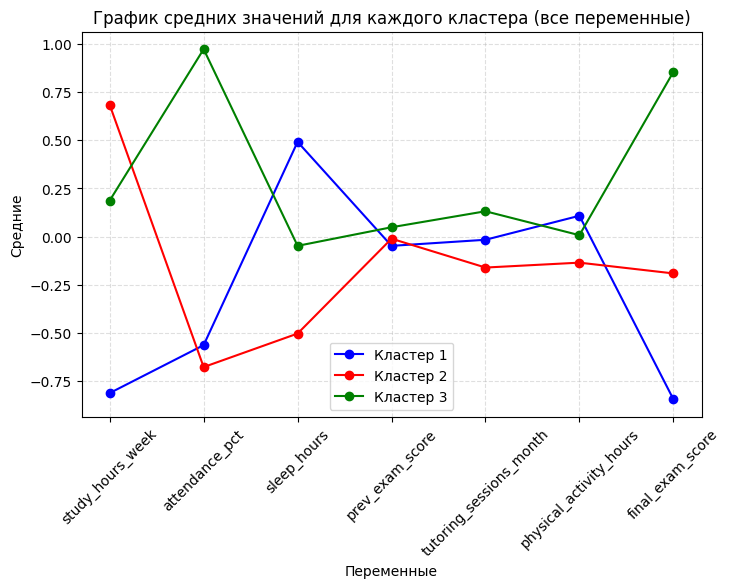

In [4]:
import matplotlib.pyplot as plt

def plot_means(vars, cluster_means):
    x = range(len(vars))                    

    plt.figure(figsize=(8, 5))
    plt.plot(x, cluster_means["Кластер 1"], marker="o", color="blue", label="Кластер 1")
    plt.plot(x, cluster_means["Кластер 2"], marker="o", color="red",  label="Кластер 2")
    plt.plot(x, cluster_means["Кластер 3"], marker="o", color="green", label="Кластер 3")
    plt.xticks(x, vars, rotation=45)
    plt.xlabel("Переменные")
    plt.ylabel("Средние")
    plt.title("График средних значений для каждого кластера (все переменные)")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()

plot_means(vars, cluster_means)

Из графика видно, что для некоторых параметров средние располагаются достаточно близко. Это свидетельствует о неудовлетворительном разбиении на группы. Исходя из анализа предыдущих таблиц и графика средних оставим в рассмотрении только три переменные: *Часы учебы/нед*, *Процент посещения* и *Итоговый балл*. Построим снова график значений, изображенный на рисунке ниже, соответствующие таблицы с результатами дисперсионного анализа и евклидовых расстояний:

Средние кластеров:


,Кластер 1,Кластер 2,Кластер 3
study_hours_week,-0.093263,0.854724,-0.846891
attendance_pct,-0.935850,0.631768,0.734359
final_exam_score,-0.742391,0.992220,0.011924


Евклидовы расстояния между кластерами:


,Кластер 1,Кластер 2,Кластер 3
Кластер 1,0.000000,6.364982,3.926545
Кластер 2,2.522892,0.000000,3.866997
Кластер 3,1.981551,1.966468,0.000000


,Переменная,Между SS,Внутри SS,F,p_value
0,study_hours_week,399.693503,544.306497,345.496139,0.0000
1,attendance_pct,601.481776,342.518224,826.225162,0.0000
2,final_exam_score,508.283438,435.716562,548.859921,0.0000


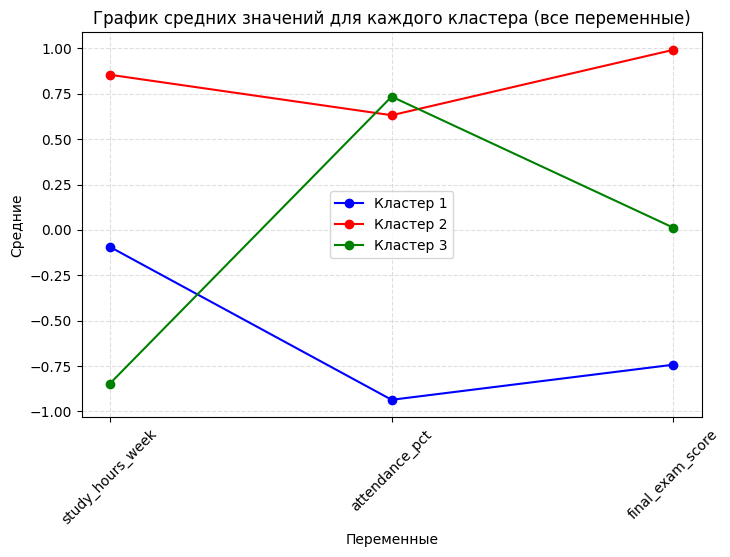

In [5]:
vars = ["study_hours_week", "attendance_pct", "final_exam_score"]
data = df[vars].dropna()
scaler = StandardScaler()   
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=vars)

df_k, cluster_means = k_means(data_scaled)
anova_table(vars, df_k)
plot_means(vars, cluster_means)

Полученные график и таблицы свидетельствуют о более успешной кластеризации.